In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def initial_probability_vector(d):
    return np.full(d, 0.5)

In [3]:
def binary_random(p):
    sample=np.random.rand()
    if sample < p:
        return 1
    return 0

In [4]:
def random_individual(p_vec):
    d = p_vec.size
    res=[]
    for k in range(d):
        res.append(binary_random(p_vec[k]))
    return np.array(res)

In [5]:
def random_population(p_vec, N):
    res=[]
    for k in range(N):
        res.append(random_individual(p_vec))
    return np.array(res)
random_population(np.array([0.5, 0.5, 0.5, 0.5]), 4)

array([[0, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 1, 1, 1]])

In [24]:
def find_best(population, evaluation_result):
    return population[np.argmin(evaluation_result)]

In [27]:
#Entropy of X
#TODO: If results will be bad, then think about logarithm base change
def variable_entropy(X):
    prob_of_one = np.sum(X) / (X.size + 1e-50)
    prob_of_zero = 1 - prob_of_one
    return -1 * (prob_of_one * np.log(prob_of_one + 1e-50) + prob_of_zero * np.log(prob_of_zero + 1e-50))

In [28]:
#Conditional entropy of X and Y
def conditional_variable_entropy(Y, X):
    prob_of_one = np.sum(X) / (X.size + 1e-50)
    prob_of_zero = 1 - prob_of_one
    return (prob_of_one * variable_entropy(Y[np.nonzero(X==1)]) + prob_of_zero * variable_entropy(Y[np.nonzero(X==0)]))
X=np.array([0,1,1,0])
Y=np.array([0,0,0,0])
print(variable_entropy(Y))

0


In [118]:
def calculate_probs(X, Y=None):
    #print(f"X:{X}")
    if Y is None:
        return np.sum(X) / (X.size + 1e-50) 
    else:
        #print(f"Y:{Y}")
        zeros_sum=np.count_nonzero(Y == 0) + 1e-50
        return 1 - (len([i for i in range(len(X)) if X[i] == 0 and Y[i] == 0]) / zeros_sum)
#for i in range(500):
#    print(calculate_probs(random_individual(initial_probability_vector(4))))

In [125]:
#function that updates probability vector
#For more details look at section 4 of
#"MIMIC: Finding Optima by Estimating Probability Densities" 
def probs_update(sample, prob_vec):
    d=len(prob_vec)
    perm=np.full(d, -1)
    perm[d-1] = np.argmin([variable_entropy(sample[:, k]) for k in range(d)])
    for i in range(d-2, -1, -1):
        possible_indices=[j for j in range(d) if j not in perm[i+1:]]
        best_possible_index = np.argmin([conditional_variable_entropy(sample[:, k], sample[:, perm[i+1]]) for k in possible_indices])
        perm[i]=possible_indices[best_possible_index]
    prob_vec_res=np.full(d, -1.0)
    res = calculate_probs(sample[:, perm[d-1]])
    #print(f"perm: {perm}")
    prob_vec_res[perm[d-1]] = res
    for i in range(d-2, -1, -1):
        res=calculate_probs(sample[:, perm[i]], sample[:, perm[i+1]])
        #print(f"res: {res}")
        prob_vec_res[perm[i]]=res
    #print(f"prob_vec_res: {prob_vec_res}")
    return prob_vec_res

In [120]:
def MIMIC(iters, d, F, N, percentile):
    p_vec=initial_probability_vector(d)
    #print(f"p_vec: {p_vec}")
    population=random_population(p_vec, N)
    #print(f"population: {population}")
    evaluation_result=F(population) * -1
    #print(f"evaluation_result: {evaluation_result}")
    theta=np.median(evaluation_result)
    #print(f"theta:{theta}")
    sample_eval_res=evaluation_result <= theta
    sample=population[sample_eval_res]
    #print(f"sample: {sample}")
    best_evaluation_results=np.full(iters, -1)
    mean_evaluation_results=np.full(iters, -1)
    worst_evaluation_results=np.full(iters, -1)
    solutions=[]
    for i in range(iters):
        best_individual=find_best(population, evaluation_result)
        best_evaluation_results[i] = np.min(evaluation_result)
        mean_evaluation_results[i] = np.mean(evaluation_result)
        worst_evaluation_results[i] = np.max(evaluation_result)
        solutions.append(best_individual)
        p_vec=probs_update(sample, p_vec)
        #print(f"p_vec: {p_vec}")
        population=random_population(p_vec, N)
        #print(f"population: {population}")
        evaluation_result=F(population) * -1
        #print(f"evaluation_result: {evaluation_result}")
        theta=np.percentile(evaluation_result, percentile)
        #print(f"theta:{theta}")
        sample_eval_res=evaluation_result <= theta
        sample=population[sample_eval_res]
        #print(f"sample: {sample}")
    return find_best(solutions, F(solutions) * -1), best_evaluation_results * -1, mean_evaluation_results * -1, worst_evaluation_results * -1

In [95]:
def plot_chart(P):
    plt.figure(figsize=(20, 7))
    plt.plot(P[1], label="Best results")
    plt.plot(P[2], label="Mean results")
    plt.plot(P[3], label="Worst results")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()

## OneMax

In [96]:
def one_max(population):
    return np.sum(population, 1)

For args : 500, 20, one_max, 50, 25


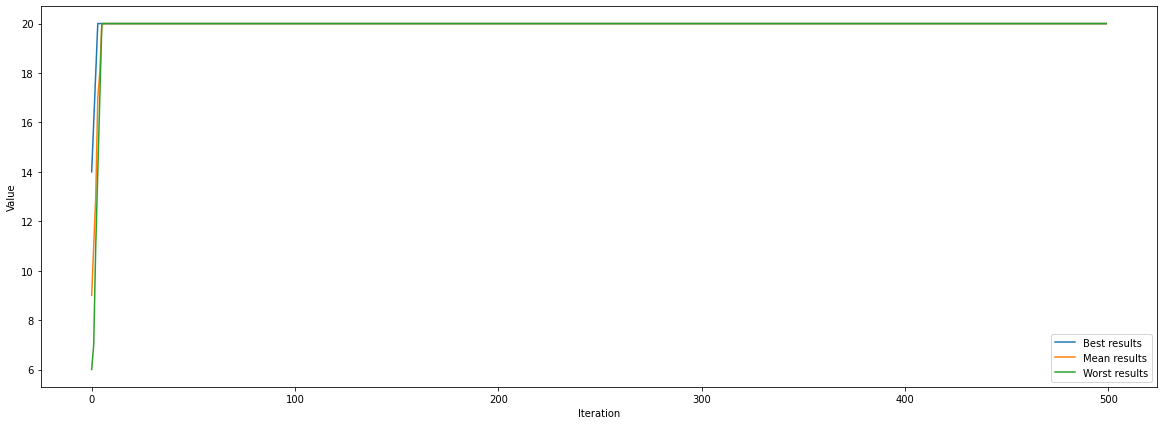

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
For args : 700, 10, one_max, 100, 30


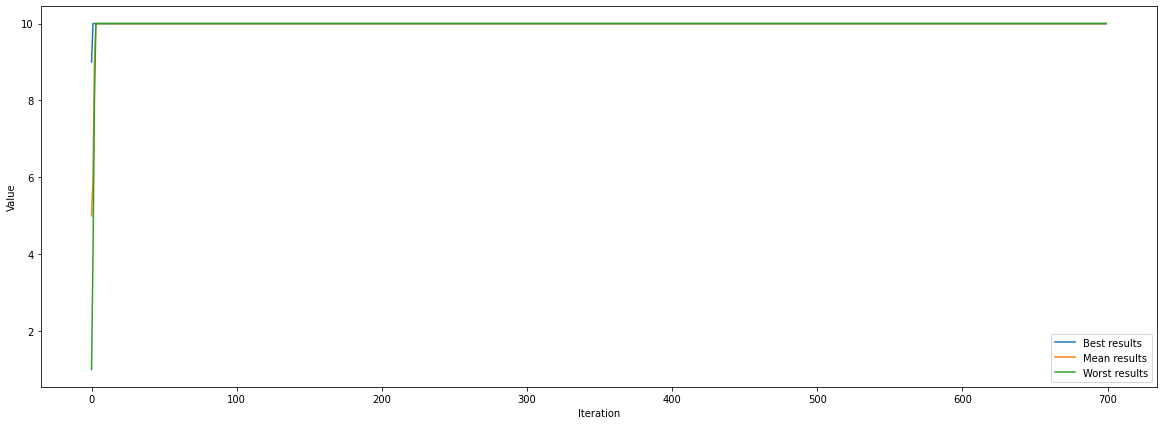

[1 1 1 1 1 1 1 1 1 1]
For args : 300, 50, one_max, 20, 15


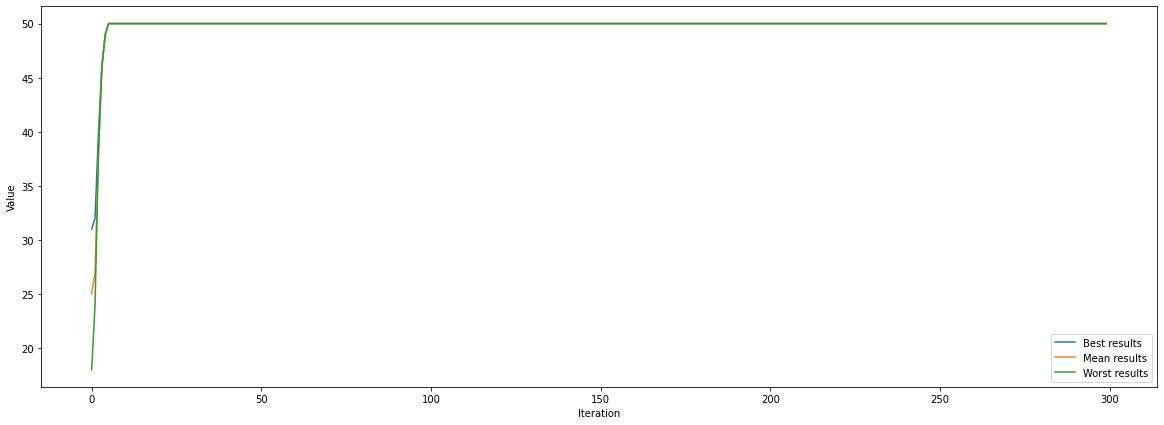

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [127]:
print("For args : 500, 20, one_max, 50, 25")
P=MIMIC(500, 20, one_max, 50, 25)
plot_chart(P)
print(P[0])
print("For args : 700, 10, one_max, 100, 30")
P=MIMIC(700, 10, one_max, 100, 30)
plot_chart(P)
print(P[0])
print("For args : 300, 50, one_max, 20, 15")
P=MIMIC(300, 50, one_max, 20, 15)
plot_chart(P)
print(P[0])'

## DeceptiveOneMax

In [128]:
def deceptive_one_max(population): 
    res = []
    for i in range(len(population)):
        if np.any(population[i]):
            res.append(np.sum(population[i]))
        else:
            res.append(population[i].size + 1)
    return np.array(res)

For args : 500, 20, deceptive_one_max, 50, 25


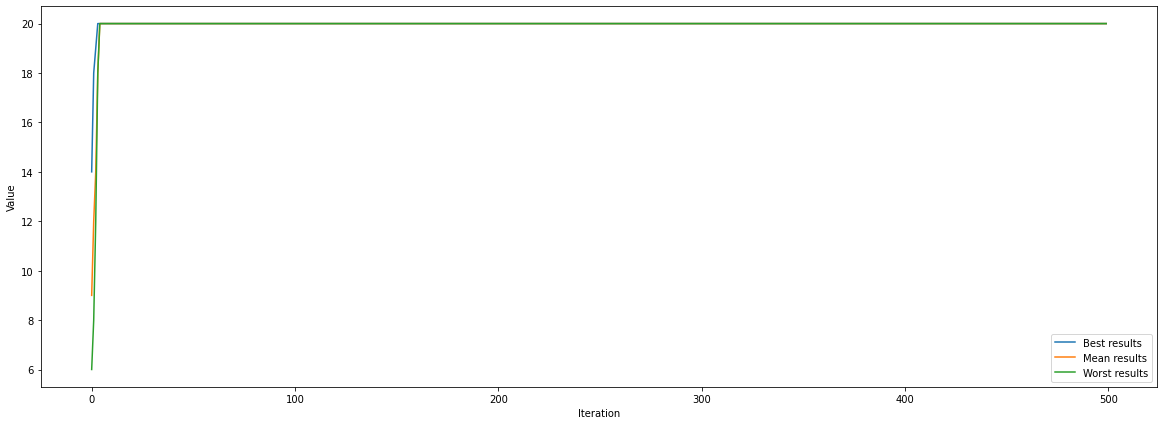

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
For args : 700, 10, deceptive_one_max, 100, 30


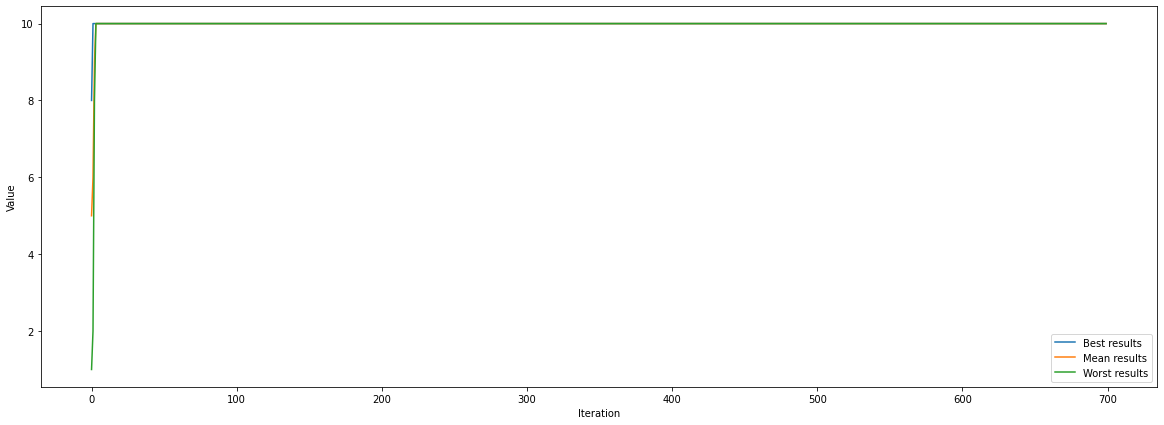

[1 1 1 1 1 1 1 1 1 1]
For args : 300, 50, deceptive_one_max, 20, 15


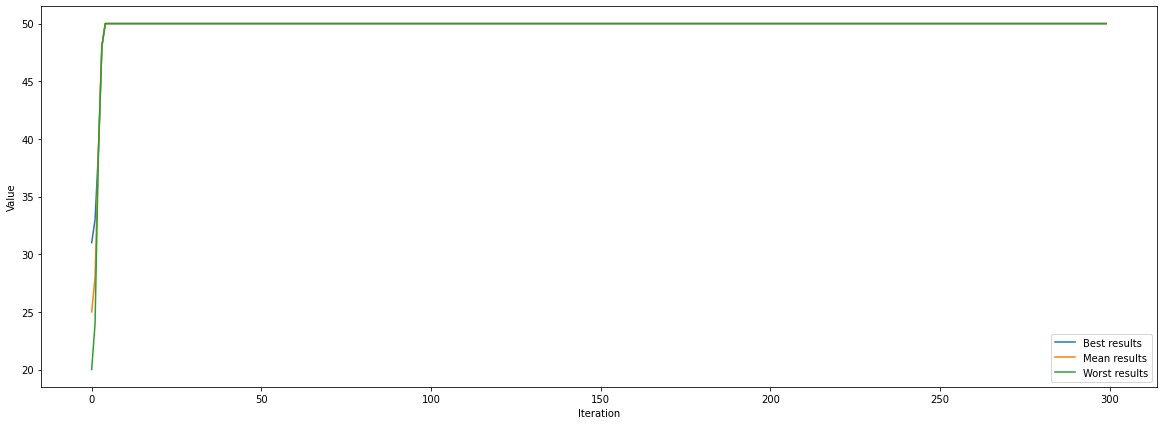

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [129]:
print("For args : 500, 20, deceptive_one_max, 50, 25")
P=MIMIC(500, 20, deceptive_one_max, 50, 25)
plot_chart(P)
print(P[0])
print("For args : 700, 10, deceptive_one_max, 100, 30")
P=MIMIC(700, 10, deceptive_one_max, 100, 30)
plot_chart(P)
print(P[0])
print("For args : 300, 50, deceptive_one_max, 20, 15")
P=MIMIC(300, 50, deceptive_one_max, 20, 15)
plot_chart(P)
print(P[0])

## KDeceptiveOneMax

In [130]:
k=5
def k_deceptive_one_max(population): 
    res = []
    for i in range(len(population)):
        ith_val=0
        for part in range(0, len(population[i]) // k):
            if np.any(population[i][part * k : part * k + k]):
                ith_val += np.sum(population[i][part * k : part * k + k]) 
            else:
                ith_val += k + 1
        res.append(ith_val)
    return np.array(res)

For args : 500, 20, k_deceptive_one_max, 50, 25


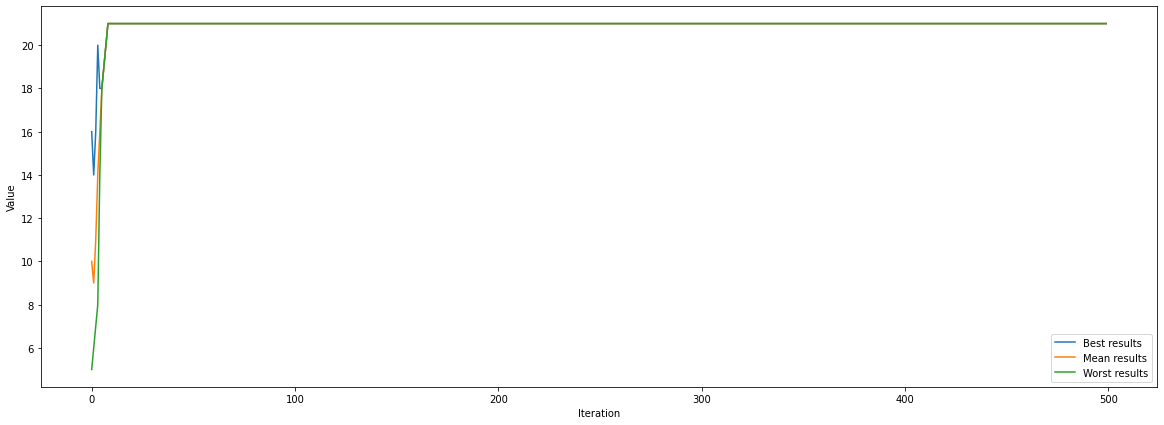

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
For args : 700, 10, k_deceptive_one_max, 100, 30


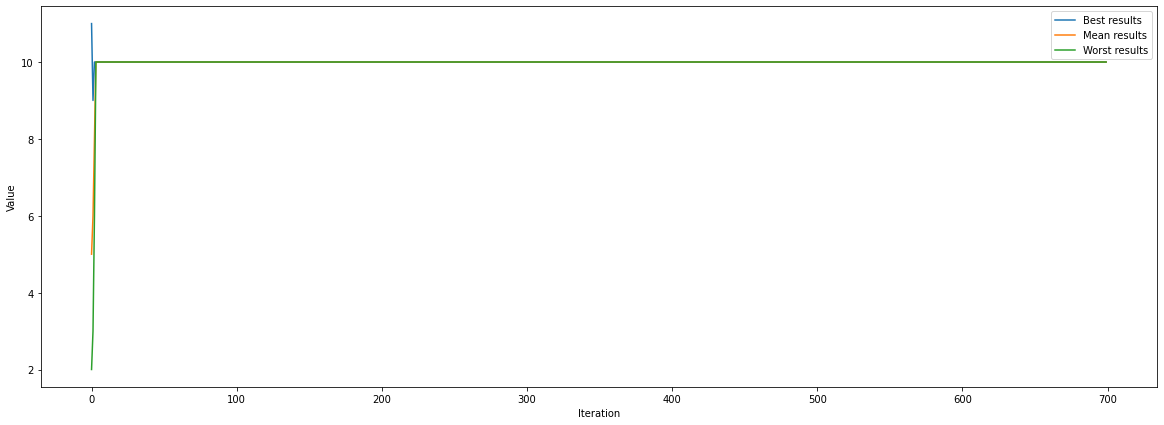

[1 1 1 1 1 0 0 0 0 0]
For args : 300, 50, k_deceptive_one_max, 20, 15


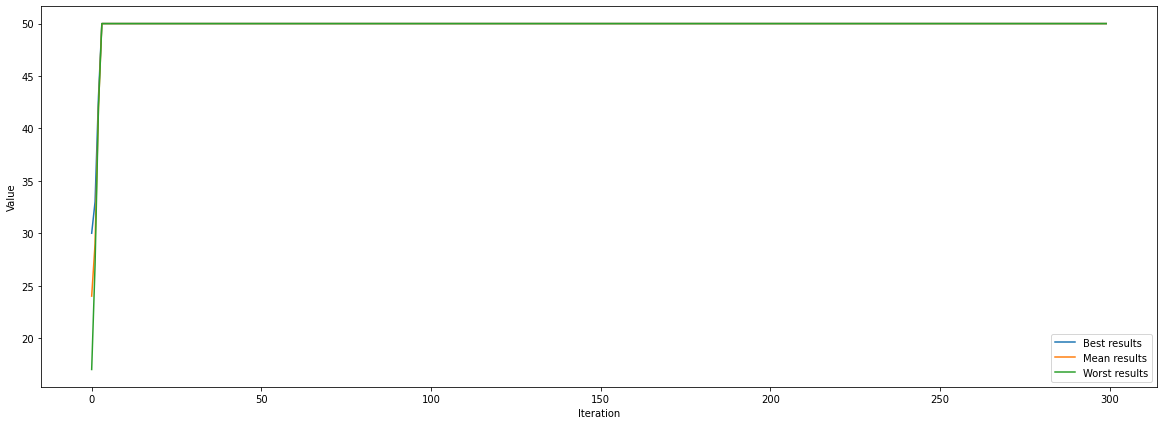

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [131]:
print("For args : 500, 20, k_deceptive_one_max, 50, 25")
P=MIMIC(500, 20, k_deceptive_one_max, 50, 25)
plot_chart(P)
print(P[0])
print("For args : 700, 10, k_deceptive_one_max, 100, 30")
P=MIMIC(700, 10, k_deceptive_one_max, 100, 30)
plot_chart(P)
print(P[0])
print("For args : 300, 50, k_deceptive_one_max, 20, 15")
P=MIMIC(300, 50, k_deceptive_one_max, 20, 15)
plot_chart(P)
print(P[0])